In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time


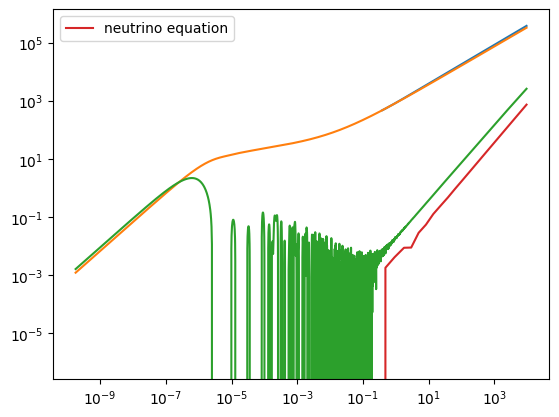

In [2]:

def TEST(kvec=[1],k_ind=0,z=800,
         mv_test=1 ,Omega_M = 0.99,
         Omega_b=0.01,PLOT_FIGUR=True,
         EdSitter=True,interpolation_type="cubic"):

    if EdSitter==True:
        Omega_M = 0.99
    
    
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T_0 / a / mv
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    delta_test      = np.empty(len(kvec))
    delta_M      = np.empty(len(kvec))
    delta_approx = np.empty(len(kvec))
    b_list = np.empty(len(kvec))
    
    # her genere 
    for kind,k in enumerate(kvec): 
        delta_class = pts[kind]["delta_cdm"]
        theta_class = pts[kind]["theta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]
        #print(theta_neutrino_class[0])
        
        tau_class = pts[kind]["tau [Mpc]"]
        a_class = pts[kind]["a"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class,kind=interpolation_type)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class,kind=interpolation_type)
        #print(len(tid_class),len(theta_neutrino_class))
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        
        t0 = tid_class[-1]
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100) 
        
        def Dfunc(t,y): 
            delta = y[0]
            t0 = tid[-1]
            d_delta = y[1]    
            H = 2/3 * t**(-1)
            a = (t/t0)**(2/3)
            c = 0
            d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta#0/(a0) * a# - (c*k)**2 * delta/a**4 

            return [d_delta,d2_delta]

        
        delta_diff = lambda t,h: (delta_interp(t+h)-delta_interp(t))/h
        start0 = [delta_interp(T0),delta_diff(T0,0.1)]
        sol = scipy.integrate.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        delta_M[kind] = sol.y[0][-1]
        delta_approx[kind] = delta0/a0 * 1
        delta_test[kind] = delta_class[-1]
        
    plt.loglog(sol.t,-sol.y[0])
    plt.loglog(tid_class,-delta_class)
    
    
    diff_neu = lambda t,h: (neu_tid(t+h)-neu_tid(t))/h
    
    def f2(t):
        C1 = np.sqrt(neu_tid(T0)**2 + (diff_neu(T0,1)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        dcdm = delta0/a0        
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 


    plt.loglog(tid_class,-delta_neutrino_class)
    plt.loglog(sol.t,-f2(sol.t),label="neutrino equation")
    plt.legend()
    


kvec1=list(np.logspace(-4,1,10))
TEST(kvec = kvec1,EdSitter=True)
    

[9.999999999999999e-05, 0.00035938136638046257, 0.001291549665014884, 0.0046415888336127815, 0.01668100537200059, 0.05994842503189409, 0.21544346900318845, 0.7742636826811277, 2.782559402207126, 10.0]
[-6.83201801e-02 -8.82361916e-01 -1.13916211e+01 -1.46379890e+02
 -1.77675265e+03 -1.45097740e+04 -6.03663501e+04 -1.46190458e+05
 -2.55526079e+05 -3.74740833e+05]


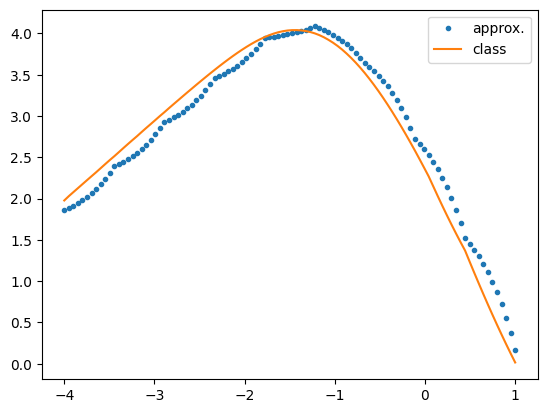

In [3]:
def TEST(kvec=[1],k_ind=0,z=800,
         mv_test=1 ,Omega_M = 0.99,
         Omega_b=0.01,PLOT_FIGUR=True,
         EdSitter=True,interpolation_type="cubic"):

    if EdSitter==True:
        Omega_M = 0.99
    
    
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T_0 / a / mv
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    delta_test      = np.empty(len(kvec))
    delta_M      = np.empty(len(kvec))
    delta_approx = np.empty(len(kvec))
    b_list = np.empty(len(kvec))
    
    # her genere 
    for kind,k in enumerate(kvec): 
        delta_class = pts[kind]["delta_cdm"]
        theta_class = pts[kind]["theta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]
        #print(theta_neutrino_class[0])
        
        tau_class = pts[kind]["tau [Mpc]"]
        a_class = pts[kind]["a"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class,kind=interpolation_type)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class,kind=interpolation_type)
        #print(len(tid_class),len(theta_neutrino_class))
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        
        t0 = tid_class[-1]
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100) 
        
        def Dfunc(t,y): 
            delta = y[0]
            t0 = tid[-1]
            d_delta = y[1]    
            H = 2/3 * t**(-1)
            a = (t/t0)**(2/3)
            c = 0
            d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta#0/(a0) * a# - (c*k)**2 * delta/a**4 

            return [d_delta,d2_delta]

        
        delta_diff = lambda t,h: (delta_interp(t+h)-delta_interp(t))/h
        start0 = [delta_interp(T0),delta_diff(T0,0.1)]
        sol = scipy.integrate.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        delta_M[kind] = sol.y[0][-1]
        delta_approx[kind] = delta0/a0 * 1
        delta_test[kind] = delta_class[-1]
    print(delta_approx)
    diff_neu = lambda t,h: (neu_tid(t+h)-neu_tid(t))/h
    
    def f2(t):
        C1 = np.sqrt(neu_tid(T0)**2 + (diff_neu(T0,1)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        dcdm = delta0/a0        
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
    
    
    logkvec = np.log10(kvec)
    delta_app_logk =  scipy.interpolate.interp1d(logkvec,np.abs(delta_approx),kind='linear')
    p_approx_logk = lambda logk: 2*np.pi**2 * delta_app_logk(logk)** 2 *  prim_interp(10**logk) * h**3  *(10**logk)**(-3)    
    kvec = np.array(kvec)
    logp_approx =  scipy.interpolate.interp1d(kvec, np.log10(2*np.pi**2 * delta_approx** 2 *  prim_interp(kvec) * h**3  *kvec**(-3)    ))
    #p_approx = lambda k: 2*np.pi**2 * delta_app(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    
    test =  scipy.interpolate.interp1d(kvec,delta_test)
    p_test = lambda k: 2*np.pi**2 * test(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    delta =  scipy.interpolate.interp1d(kvec,delta_M)
    p_min = lambda k: 2*np.pi**2 * delta(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    #delta_M
    
    delta_approx_at_kvec = 2*np.pi**2 * delta_app_logk(logkvec)** 2 *  prim_interp(10**logkvec) * h**3  *(10**logkvec)**(-3)    
    
    k =np.linspace(kvec[0],kvec[-1],100)
    k =np.logspace(np.log10(kvec[0]),np.log10(kvec[-1]),100)
    kvec = np.array(kvec)
    
    #plt.figure(np.random.randint(1,324234))
    #plt.semilogx(k,-test(k))
    #plt.plot(kvec,-delta_test)
    
    plt.figure(np.random.randint(1,324234))
    #plt.loglog(kvec, 2*np.pi**2 * delta_test** 2 *  prim_interp(kvec) * h**3  *kvec**(-3)    )
    plt.plot(np.log10(k),logp_approx(k),'.',label="approx.")
    #plt.loglog(k,p_min(k),label="sim")
    #plt.plot(np.log10(k),p_approx(k),label="approx")
    #plt.plot(np.log10(k), p_approx_logk(np.log10(k)), '.-',label='approx')
    #plt.plot(logkvec, delta_approx_at_kvec, label='linear?')
    plt.plot(np.log10(k),np.log10(p(k)), label="class")
    #plt.plot(logkvec, p_approx_logk(logkvec), 'r.',label='log approx')
   # plt.semilogx(k,p_test(k),label="test")
    #plt.yscale('log')
    plt.legend()

kvec1=list(np.logspace(-4,1,10))
print(kvec1)
TEST(kvec = kvec1,EdSitter=True)
#TEST(kvec = kvec1,EdSitter=False)

Det er værd at bemærke at min bispektrum er 2 gange større end Johans Bispektrum, hvilket kan fikses ved at fjerne 2 faktoren i Bispektret


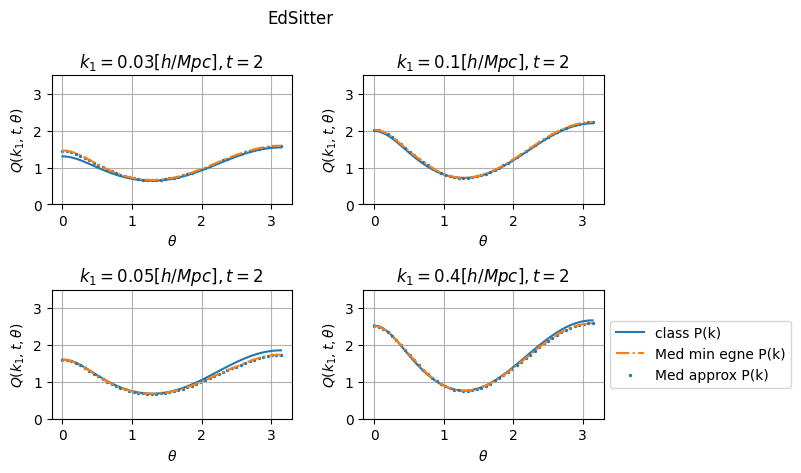

In [4]:
def TEST(kvec=[1],k_ind=0,z=800,
         mv_test=1 ,Omega_M = 0.99,
         Omega_b=0.01,PLOT_FIGUR=True,
         EdSitter=True,interpolation_type="cubic"):

    if EdSitter==True:
        Omega_M = 0.99
    
    
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T_0 / a / mv
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    delta_test      = np.empty(len(kvec))
    delta_M      = np.empty(len(kvec))
    delta_approx = np.empty(len(kvec))
    b_list = np.empty(len(kvec))
    
    # her genere 
    for kind,k in enumerate(kvec): 
        delta_class = pts[kind]["delta_cdm"]
        theta_class = pts[kind]["theta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]
        #print(theta_neutrino_class[0])
        
        tau_class = pts[kind]["tau [Mpc]"]
        a_class = pts[kind]["a"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class,kind=interpolation_type)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class,kind=interpolation_type)
        #print(len(tid_class),len(theta_neutrino_class))
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        
        t0 = tid_class[-1]
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100) 
        
        def Dfunc(t,y): 
            delta = y[0]
            t0 = tid[-1]
            d_delta = y[1]    
            H = 2/3 * t**(-1)
            a = (t/t0)**(2/3)
            c = 0
            d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta#0/(a0) * a# - (c*k)**2 * delta/a**4 

            return [d_delta,d2_delta]

        
        delta_diff = lambda t,h: (delta_interp(t+h)-delta_interp(t))/h
        start0 = [delta_interp(T0),delta_diff(T0,0.1)]
        sol = scipy.integrate.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        delta_M[kind] = sol.y[0][-1]
        delta_approx[kind] = delta0/a0 * 1
        delta_test[kind] = delta_class[-1]
   
    diff_neu = lambda t,h: (neu_tid(t+h)-neu_tid(t))/h
    
    def f2(t):
        C1 = np.sqrt(neu_tid(T0)**2 + (diff_neu(T0,1)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        dcdm = delta0/a0        
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
    
    delta_app =  scipy.interpolate.interp1d(kvec,delta_approx)
    p_approx = lambda k: 2*np.pi**2 * delta_app(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    test =  scipy.interpolate.interp1d(kvec,delta_test)
    p_test = lambda k: 2*np.pi**2 * test(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    delta =  scipy.interpolate.interp1d(kvec,delta_M)
    p_min = lambda k: 2*np.pi**2 * delta(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    #k =np.linspace(kvec[0],kvec[-1],100)
  
    def K(k1,t,theta):
        k2 = k1 * t
        bn = 1
        an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
    
    def reduceret_B_spektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p(k1)*p(k2) * K(k1,t,theta)
                    +p(k3)*p(k1) * K(k3,t3,theta3) 
                    +p(k2)*p(k3) * K(k2,t2,theta2)) / (p(k1)*p(k2)+p(k3)*p(k1)+p(k2)*p(k3))
        return res
      
    
    def Q_min(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p_min(k1)*p_min(k2) * K(k1,t,theta)
                    +p_min(k3)*p_min(k1) * K(k3,t3,theta3) 
                    +p_min(k2)*p_min(k3) * K(k2,t2,theta2))/(p_min(k1)*p_min(k2)+p_min(k3)*p_min(k1)+p_min(k2)*p_min(k3))
        return res
    
    def Q_approx(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta        
        t2 = k3/k2
        t3 = k1/k3
        res =    (2 *p_approx(k1)*p_approx(k2) * K(k1,t,theta)
                    +2 *p_approx(k3)*p_approx(k1) * K(k3,t3,theta3) 
                    +2 *p_approx(k2)*p_approx(k3) * K(k2,t2,theta2))/(p_approx(k1)*p_approx(k2)+p_approx(k3)*p_approx(k1)+p_approx(k2)*p_approx(k3))
        return res
        
    def Bispektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res
    
    
    fig = plt.figure(np.random.randint(0,1110000))
    
    ax = fig.subplots(nrows=2, ncols=2)
    #plt.figure(12312312312123)
    if EdSitter == True:
        fig.suptitle("EdSitter")
    else:
        fig.suptitle("Not EdSitter")
    theta = np.linspace(0,np.pi,50)
    #k1 = 0.03 / h
    
    k_list_test = np.array([0.03,0.1,0.05,0.4]) 
    #print(k_list_test)
    t = 2
    k_i = 0
    for row in ax:
        for col in row:
            k1 = k_list_test[k_i]/h
            #print(k1)
            col.plot(theta,reduceret_B_spektrum(k1,t,theta),label="class P(k)")     
            col.plot(theta,Q_min(k1,t,theta),"-.",label="Med min egne P(k)")
            col.scatter(theta,Q_approx(k1,t,theta),s=2,label="Med approx P(k)")
            col.set_title("$k_1 = %s [h/Mpc] , t = %s$"% (k_list_test[k_i],t))
            k_i += 1
            
            col.set_xlabel("$\\theta$")
            col.set_ylim([0,3.5])
            col.grid()
            col.set_ylabel("$Q(k_1,t,\\theta)$",rotation=90)
    
    plt.subplots_adjust(top=1.2)
    fig.tight_layout(pad=1.2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    """
    tol = 1e-3
    n = 30
    m = n//5
    mat = np.empty((n,n))
    k1 = 0.15
    t = 2
    for i in range(n):
        for j in range(n):
            t  = 1/2 * ( 1 + i/n)
            theta = np.pi - np.arccos(1/2*( 1 + j/n))
            if 2 * t * np.cos(np.pi - theta) >= 1:
                mat[i,j] =  Bispektrum(k1/h,t,theta)
            else:
                mat[i,j]=None
        #list)
    plt.matshow(mat,interpolation="spline16")
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_bottom()
    xtick_numbers = np.array([np.pi - np.arccos(1/2*( 1 + j/n)) for j in range(n)])
    x = np.cos(np.pi-xtick_numbers[::m])
    plt.xticks([i for i in range(n)][::m],np.round(x,1))
    ytick_numbers = np.array([1/2 * ( 1+ j/n) for j in range(n)])[::m]
    plt.yticks([i for i in range(n)][::m],np.round(ytick_numbers,1))
    plt.ylabel("t",rotation=0)
    plt.xlabel("$cos(\pi-\\theta)$")
    plt.title("Matter Bispectrum $k_1=%s [h/Mpc]$" % k1)
    plt.colorbar()"""
    print("Det er værd at bemærke at min bispektrum er 2 gange større end Johans Bispektrum, hvilket kan fikses ved at fjerne 2 faktoren i Bispektret")
    
    
    def Bispektrum_med_z(k1,t,theta,zend=0):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        
        t3 = k1/k3
        delta_approx = np.empty(len(kvec))
        for kind,k in enumerate(kvec): 
            delta_class = pts[kind]["delta_cdm"]
            tau_class = pts[kind]["tau [Mpc]"]
            a_class = pts[kind]["a"]
            interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class,kind=interpolation_type)
            delta_interp = scipy.interpolate.interp1d(tau_class,delta_class,kind=interpolation_type)
            a0 = 1/(1+z)
            T0 = float(interp_tau_from_a(a0))
            delta0 = delta_interp(T0) * 1/(1+zend)
            #print(delta0)

            delta_approx[kind] = delta0/a0 

        delta_app =  scipy.interpolate.interp1d(kvec,delta_approx)
        #print("hej")
        #print(f"{delta_app(1)=}")
        p = lambda k: 2*np.pi**2 * delta_app(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
        #print(f"{p(1)=}")
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res
    
    k = np.logspace(-2,np.log10(2),20) / h
    #print(k)
    #print(f"{Bispektrum(1,1,np.pi/3)=}")
    """fig = plt.figure(np.random.randint(0,1110000))
    plt.title(" Equilateral Matter Bispectrum for forskellige a-værdier")
    plt.loglog(k,k**6 * Bispektrum_med_z(k,1,np.pi/3),label="a=1")
    plt.loglog(k,k**6 * Bispektrum_med_z(k,1,np.pi/3,zend=1),label="a=0.5")
    plt.loglog(k,k**6 * Bispektrum_med_z(k,1,np.pi/3,zend=9),label="a=0.1")
    plt.ylim([1e-17,1e7])
    plt.legend()
    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$k^6 B(k_1,\\theta,t)$")
    fig = plt.figure(np.random.randint(0,1110000))
    plt.loglog(k,Bispektrum(k,1,np.pi/3))
    plt.loglog(k,Bispektrum(k,2,np.pi/3))
    plt.loglog(k,Bispektrum(k,3,np.pi/3))
    #plt.loglog(k,Bispektrum(k,4,np.pi/3))
    plt.xlabel("k [h/Mpc]")
    
    plt.ylabel("$B(k_1,\\theta,t)$")
    
    fig = plt.figure(np.random.randint(0,1110000))
    k = np.logspace(-2,np.log10(2),20) / h
    plt.loglog(k,K(k,t,theta))"""
    
kvec1=list(np.logspace(-4,1,10))
TEST(kvec = kvec1,EdSitter=True)
#TEST(kvec = kvec1,EdSitter=False)

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


Det er værd at bemærke at min bispektrum er 2 gange større end Johans Bispektrum, hvilket kan fikses ved at fjerne 2 faktoren i Bispektret


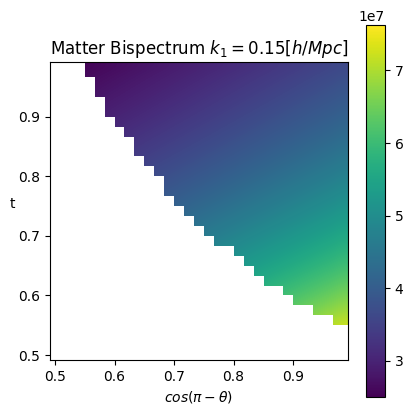

In [5]:
def TEST(kvec=[1],k_ind=0,z=800,
         mv_test=1 ,Omega_M = 0.99,
         Omega_b=0.01,PLOT_FIGUR=True,
         EdSitter=True,interpolation_type="cubic"):

    if EdSitter==True:
        Omega_M = 0.99
    
    
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T_0 / a / mv
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    delta_test      = np.empty(len(kvec))
    delta_M      = np.empty(len(kvec))
    delta_approx = np.empty(len(kvec))
    b_list = np.empty(len(kvec))
    
    # her genere 
    for kind,k in enumerate(kvec): 
        delta_class = pts[kind]["delta_cdm"]
        theta_class = pts[kind]["theta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]
        #print(theta_neutrino_class[0])
        
        tau_class = pts[kind]["tau [Mpc]"]
        a_class = pts[kind]["a"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class,kind=interpolation_type)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class,kind=interpolation_type)
        #print(len(tid_class),len(theta_neutrino_class))
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        
        t0 = tid_class[-1]
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100) 
        
        def Dfunc(t,y): 
            delta = y[0]
            t0 = tid[-1]
            d_delta = y[1]    
            H = 2/3 * t**(-1)
            a = (t/t0)**(2/3)
            c = 0
            d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta#0/(a0) * a# - (c*k)**2 * delta/a**4 

            return [d_delta,d2_delta]

        
        delta_diff = lambda t,h: (delta_interp(t+h)-delta_interp(t))/h
        start0 = [delta_interp(T0),delta_diff(T0,0.1)]
        sol = scipy.integrate.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        delta_M[kind] = sol.y[0][-1]
        delta_approx[kind] = delta0/a0 * 1
        delta_test[kind] = delta_class[-1]
   
    diff_neu = lambda t,h: (neu_tid(t+h)-neu_tid(t))/h
    
    def f2(t):
        C1 = np.sqrt(neu_tid(T0)**2 + (diff_neu(T0,1)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        dcdm = delta0/a0        
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
    
    delta_app =  scipy.interpolate.interp1d(kvec,delta_approx)
    p_approx = lambda k: 2*np.pi**2 * delta_app(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    test =  scipy.interpolate.interp1d(kvec,delta_test)
    p_test = lambda k: 2*np.pi**2 * test(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    delta =  scipy.interpolate.interp1d(kvec,delta_M)
    p_min = lambda k: 2*np.pi**2 * delta(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    #k =np.linspace(kvec[0],kvec[-1],100)
  
    def K(k1,t,theta):
        k2 = k1 * t
        bn = 1
        an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
    
    def reduceret_B_spektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p(k1)*p(k2) * K(k1,t,theta)
                    +p(k3)*p(k1) * K(k3,t3,theta3) 
                    +p(k2)*p(k3) * K(k2,t2,theta2)) / (p(k1)*p(k2)+p(k3)*p(k1)+p(k2)*p(k3))
        return res
      
    
    def Q_min(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p_min(k1)*p_min(k2) * K(k1,t,theta)
                    +p_min(k3)*p_min(k1) * K(k3,t3,theta3) 
                    +p_min(k2)*p_min(k3) * K(k2,t2,theta2))/(p_min(k1)*p_min(k2)+p_min(k3)*p_min(k1)+p_min(k2)*p_min(k3))
        return res
    
    def Q_approx(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta        
        t2 = k3/k2
        t3 = k1/k3
        res =    (2 *p_approx(k1)*p_approx(k2) * K(k1,t,theta)
                    +2 *p_approx(k3)*p_approx(k1) * K(k3,t3,theta3) 
                    +2 *p_approx(k2)*p_approx(k3) * K(k2,t2,theta2))/(p_approx(k1)*p_approx(k2)+p_approx(k3)*p_approx(k1)+p_approx(k2)*p_approx(k3))
        return res
        
    def Bispektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res
    
    """
    fig = plt.figure(np.random.randint(0,1110000))
    
    ax = fig.subplots(nrows=2, ncols=2)
    #plt.figure(12312312312123)
    if EdSitter == True:
        fig.suptitle("EdSitter")
    else:
        fig.suptitle("Not EdSitter")
    theta = np.linspace(0,np.pi,50)
    #k1 = 0.03 / h
    
    k_list_test = np.array([0.03,0.1,0.05,0.4]) 
    #print(k_list_test)
    t = 2
    k_i = 0
    for row in ax:
        for col in row:
            k1 = k_list_test[k_i]/h
            #print(k1)
            col.plot(theta,reduceret_B_spektrum(k1,t,theta),label="class P(k)")     
            col.plot(theta,Q_min(k1,t,theta),"-.",label="Med min egne P(k)")
            col.scatter(theta,Q_approx(k1,t,theta),s=2,label="Med approx P(k)")
            col.set_title("$k_1 = %s [h/Mpc] , t = %s$"% (k_list_test[k_i],t))
            k_i += 1
            
            col.set_xlabel("$\\theta$")
            col.set_ylim([0,3.5])
            col.grid()
            col.set_ylabel("$Q(k_1,t,\\theta)$",rotation=90)
    
    plt.subplots_adjust(top=1.2)
    fig.tight_layout(pad=1.2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))"""
    
    tol = 1e-3
    n = 30
    m = n//5
    mat = np.empty((n,n))
    k1 = 0.15
    t = 2
    for i in range(n):
        for j in range(n):
            t  = 1/2 * ( 1 + i/n)
            theta = np.pi - np.arccos(1/2*( 1 + j/n))
            if 2 * t * np.cos(np.pi - theta) >= 1:
                mat[i,j] =  Bispektrum(k1/h,t,theta)
            else:
                mat[i,j]=None
        #list)
    plt.matshow(mat,interpolation="spline16")
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_bottom()
    xtick_numbers = np.array([np.pi - np.arccos(1/2*( 1 + j/n)) for j in range(n)])
    x = np.cos(np.pi-xtick_numbers[::m])
    plt.xticks([i for i in range(n)][::m],np.round(x,1))
    ytick_numbers = np.array([1/2 * ( 1+ j/n) for j in range(n)])[::m]
    plt.yticks([i for i in range(n)][::m],np.round(ytick_numbers,1))
    plt.ylabel("t",rotation=0)
    plt.xlabel("$cos(\pi-\\theta)$")
    plt.title("Matter Bispectrum $k_1=%s [h/Mpc]$" % k1)
    plt.colorbar()
    print("Det er værd at bemærke at min bispektrum er 2 gange større end Johans Bispektrum, hvilket kan fikses ved at fjerne 2 faktoren i Bispektret")
    
    
    
    
kvec1=list(np.logspace(-4,1,10))
TEST(kvec = kvec1,EdSitter=True)
#TEST(kvec = kvec1,EdSitter=False)

Det er værd at bemærke at min bispektrum er 2 gange større end Johans Bispektrum, hvilket kan fikses ved at fjerne 2 faktoren i Bispektret
p(k1)=None
p(k2)=None
K(k1,t,theta)=array([0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429,
       0.28571429, 0.28571429, 0.28571429, 0.28571429, 0.28571429])


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

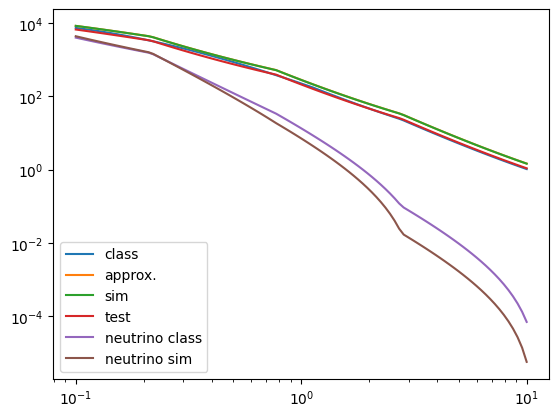

<Figure size 640x480 with 0 Axes>

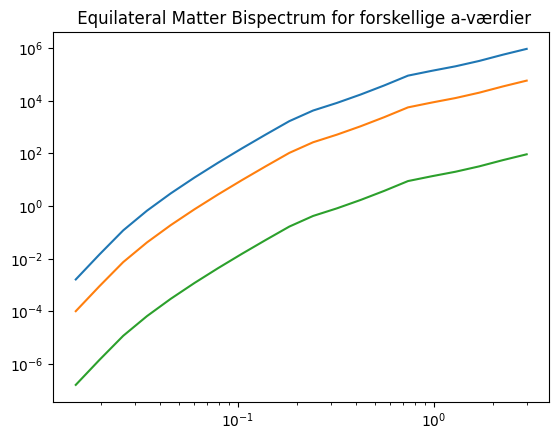

In [6]:
def TEST(kvec=[1],k_ind=0,z=800,
         mv_test=1 ,Omega_M = 0.99,
         Omega_b=0.01,PLOT_FIGUR=True,
         EdSitter=True,interpolation_type="cubic"):

    if EdSitter==True:
        Omega_M = 0.99
    
    
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="cubic")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    mv = mv_test * 1e-6

    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        return cs_factor *T_0 / a / mv
    
    c = cs(1)
    
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    delta_test      = np.empty(len(kvec))
    delta_M      = np.empty(len(kvec))
    delta_approx = np.empty(len(kvec))
    b_list = np.empty(len(kvec))
    d_neu_sim = np.empty(len(kvec))
    d_neu = np.empty(len(kvec))
    # her genere 
    for kind,k in enumerate(kvec): 
        delta_class = pts[kind]["delta_cdm"]
        theta_class = pts[kind]["theta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]
        #print(theta_neutrino_class[0])
        
        tau_class = pts[kind]["tau [Mpc]"]
        a_class = pts[kind]["a"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class,kind=interpolation_type)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class,kind=interpolation_type)
        #print(len(tid_class),len(theta_neutrino_class))
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        theta_tid = scipy.interpolate.interp1d(tid_class,theta_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        
        t0 = tid_class[-1]
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100) 
        
        def Dfunc(t,y): 
            delta = y[0]
            t0 = tid[-1]
            d_delta = y[1]    
            H = 2/3 * t**(-1)
            a = (t/t0)**(2/3)
            c = 0
            d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta#0/(a0) * a# - (c*k)**2 * delta/a**4 

            return [d_delta,d2_delta]

        
        delta_diff = lambda t,h: (delta_interp(t+h)-delta_interp(t))/h
        start0 = [delta_interp(T0),delta_diff(T0,0.1)]
        sol = scipy.integrate.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        
        
        
        def func(t,y): 
            delta = y[0]
            t0 = tid[-1]
            d_delta = y[1]    
            H = 2/3 * t**(-1)
            a = (t/t0)**(2/3)
            c = 0
            d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta0/(a0) * a - (c*k)**2 * delta/a**4 

            return [d_delta,d2_delta]

        
        #delta_diff = lambda t,h: (delta_interp(t+h)-delta_interp(t))/h
        start0 = [neu_tid(T0),theta_neu_tid(T0)]
        sol_test = scipy.integrate.solve_ivp(func, t_span = tspan, y0 = start0)
        
        delta_M[kind] = sol.y[0][-1]
        delta_approx[kind] = delta0/a0 * 1
        delta_test[kind] = delta_class[-1]
        def f2(t):
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
            dcdm = delta0/a0        
            a = (t/t0)**(2/3)
            val = 3 * cs(a) * k * t0 * np.sqrt(a)        
            return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 

        d_neu[kind] = delta_neutrino_class[-1]
        d_neu_sim[kind] = f2(t0)
    """
    plt.loglog(sol.t,-sol.y[0])
    plt.loglog(tid_class,-f2(tid_class),label="neu. lig. ")
    plt.loglog(tid_class,-delta_class)
    plt.loglog(sol_test.t,-sol_test.y[0],label="neu")
    plt.legend()"""
    
    diff_neu = lambda t,h: (neu_tid(t+h)-neu_tid(t))/h
 
 
    delta_app =  scipy.interpolate.interp1d(kvec,delta_approx)
    p_approx = lambda k: 2*np.pi**2 * delta_app(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    test =  scipy.interpolate.interp1d(kvec,delta_test)
    p_test = lambda k: 2*np.pi**2 * test(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    delta =  scipy.interpolate.interp1d(kvec,delta_M)
    p_min = lambda k: 2*np.pi**2 * delta(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    
    delta_nu_class =  scipy.interpolate.interp1d(kvec,d_neu)
    p_neu_class = lambda k: 2*np.pi**2 * delta_nu_class(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    
    delta_nu_sim =  scipy.interpolate.interp1d(kvec,d_neu_sim)
    p_neu_sim = lambda k: 2*np.pi**2 * delta_nu_sim(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
     
    
    k =np.logspace(-1,np.log10(kvec[-1]),100)
    #k =np.linspace((kvec[0]),(kvec[-1]),100)
    
    plt.figure(np.random.randint(1,324234))
    #plt.loglog(k,np.abs(p_approx(k)-p_min(k))) 
    
    plt.loglog(k,p(k),label="class")
    plt.loglog(k,p_approx(k),label="approx.")
    plt.loglog(k,p_min(k),label="sim")
    plt.loglog(k,p_test(k),label="test")
    plt.loglog(k,p_neu_class(k),label="neutrino class")
    plt.loglog(k,p_neu_sim(k),label="neutrino sim")
    plt.legend()
    
        
    
    def K(k1,t,theta):
        k2 = k1 * t
        bn=1
        an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
    
    def reduceret_B_spektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p(k1)*p(k2) * K(k1,t,theta)
                    +p(k3)*p(k1) * K(k3,t3,theta3) 
                    +p(k2)*p(k3) * K(k2,t2,theta2)) / (p(k1)*p(k2)+p(k3)*p(k1)+p(k2)*p(k3))
        return res
      
    
    def Q_min(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  2 *  (p_min(k1)*p_min(k2) * K(k1,t,theta)
                    +p_min(k3)*p_min(k1) * K(k3,t3,theta3) 
                    +p_min(k2)*p_min(k3) * K(k2,t2,theta2))/(p_min(k1)*p_min(k2)+p_min(k3)*p_min(k1)+p_min(k2)*p_min(k3))
        return res
    
    def Q_approx(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta        
        t2 = k3/k2
        t3 = k1/k3
        res =    (2 *p_approx(k1)*p_approx(k2) * K(k1,t,theta)
                    +2 *p_approx(k3)*p_approx(k1) * K(k3,t3,theta3) 
                    +2 *p_approx(k2)*p_approx(k3) * K(k2,t2,theta2))/(p_approx(k1)*p_approx(k2)+p_approx(k3)*p_approx(k1)+p_approx(k2)*p_approx(k3))
        return res
        
    def Bispektrum(k1,t,theta):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res
    
    print("Det er værd at bemærke at min bispektrum er 2 gange større end Johans Bispektrum, hvilket kan fikses ved at fjerne 2 faktoren i Bispektret") 
    def f2(t,kvec=kvec,z=z,kind=0):
        a0 = 1/(1+z)
        #print(kind)
        theta_class = pts[kind]["theta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]
        tau_class = pts[kind]["tau [Mpc]"]
        a_class = pts[kind]["a"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type)
        delta_class = pts[kind]["delta_cdm"]
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        t0 = tid_class[-1]
        a0 = 1/(1+z) 
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        k = kvec[kind]
        C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
        C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
        dcdm = delta0/a0        
        a = (t/t0)**(2/3)
        val = 3 * cs(a) * k * t0 * np.sqrt(a)        
        return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
    
    #print(f"{f2(t0)=}")
    f = np.array([f2(t0,kvec,z,i) for i,kj in enumerate(kvec)])
    #print(f)
    
    delta_f =  scipy.interpolate.interp1d(kvec,f)
    p_neu_eq = lambda k: 2*np.pi**2 * delta_f(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    #print(p_neu_eq(np.array(kvec)))
    
    def neutrino_Bispektrum(k1,t,theta):
        #print(p_neu_eq(2))
        def p(k):
            p_neu_eq(k)
        
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        t3 = k1/k3
        print(f"{p(k1)=}")
        print(f"{p(k2)=}")
        print(f"{K(k1,t,theta)=}")
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res
    
    fig = plt.figure(np.random.randint(0,1110000))
    def Bispektrum_med_z(k1,t,theta,zend=0):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        theta3 = np.pi - theta2 - theta
        t2 = k3/k2
        
        t3 = k1/k3
        delta_approx = np.empty(len(kvec))
        for kind,k in enumerate(kvec): 
            delta_class = pts[kind]["delta_cdm"]
            tau_class = pts[kind]["tau [Mpc]"]
            a_class = pts[kind]["a"]
            interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class,kind=interpolation_type)
            delta_interp = scipy.interpolate.interp1d(tau_class,delta_class,kind=interpolation_type)
            a0 = 1/(1+z)
            T0 = float(interp_tau_from_a(a0))
            delta0 = delta_interp(T0) * 1/(1+zend)
            #print(delta0)

            delta_approx[kind] = delta0/a0 

        delta_app =  scipy.interpolate.interp1d(kvec,delta_approx)
        #print("hej")
        #print(f"{delta_app(1)=}")
        p = lambda k: 2*np.pi**2 * delta_app(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
        #print(f"{p(1)=}")
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res
    
    k = np.logspace(-2,np.log10(2),20) / h
    fig = plt.figure(np.random.randint(0,1110000))
    plt.title(" Equilateral Matter Bispectrum for forskellige a-værdier")
    plt.loglog(k,k**6 * Bispektrum_med_z(k,1,np.pi/3),label="a=1")
    plt.loglog(k,k**6 * Bispektrum_med_z(k,1,np.pi/3,zend=1),label="a=0.5")
    plt.loglog(k,k**6 * Bispektrum_med_z(k,1,np.pi/3,zend=9),label="a=0.1")
    #k = list(np.logspace(-2,np.log10(2),20) / h)
    plt.loglog(k,k**6 * neutrino_Bispektrum(k,1,np.pi/3),label="neutrino test")
    plt.ylim([1e-17,1e7])
    plt.legend()
    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$k^6 B(k_1,\\theta,t)$")
    
kvec1=list(np.logspace(-4,1,10))
TEST(kvec = kvec1,EdSitter=True)
#TEST(kvec = kvec1,EdSitter=False)